In [1]:
import numpy as np
from magnitude_function import *
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/workspace/mnt/local/data/pgurevich/miniconda3/envs/magnitude/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download embeddings

EMB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/embeddings_128.pt"
LAB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/labels.pt"

embs = torch.load(EMB_PATH)
labs = torch.load(LAB_PATH)

/tmp/ipykernel_156598/2321523706.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(EMB_PATH)
/tmp/ipykernel_156598/2321523706.py:7: FutureWarning: You ar

In [3]:
reals_inds = torch.where(labs == 0)[0]
generated_inds = torch.where(labs == 1)[0]

reals = embs[reals_inds]
gens = embs[generated_inds]


Text(0, 0.5, 'Normalized magnitude')

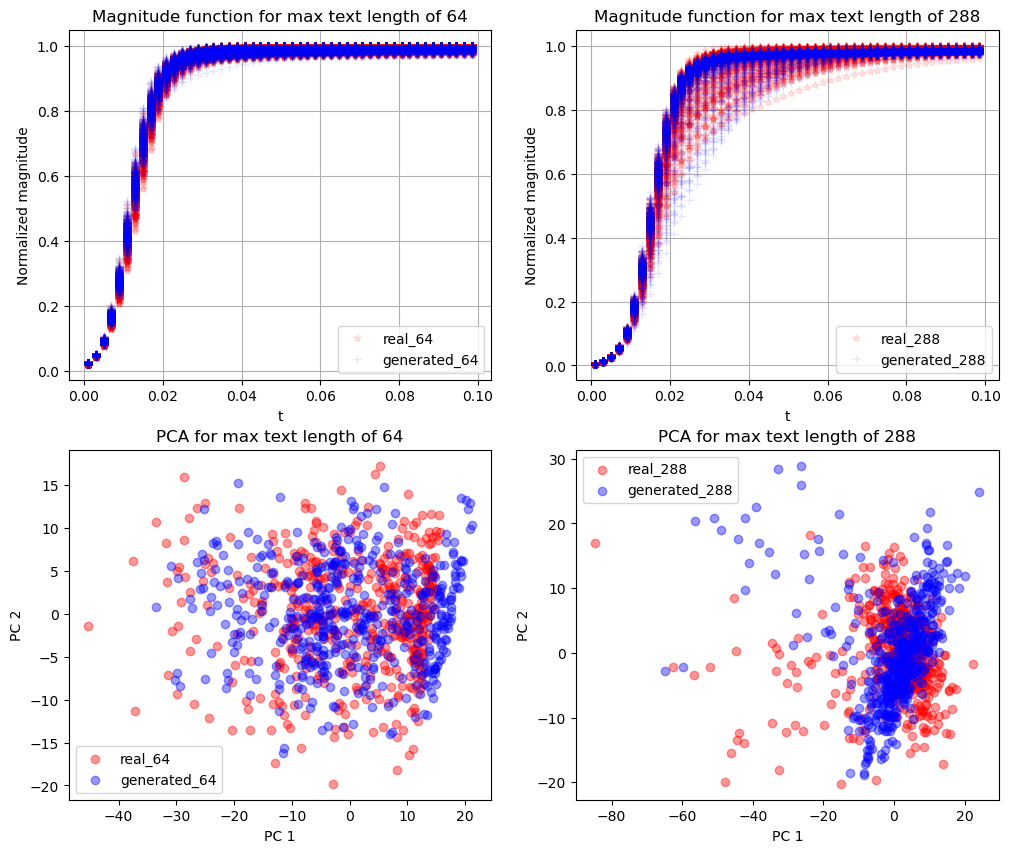

In [4]:


handles = []
colors = [('red', 'blue'), ('red', 'blue')]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))



for k, i, cols in zip([0, 1], [64, 288], colors):
    path = f"/workspace/mnt/local/data/pgurevich/magnitude/magnitude_f_{i}.pkl"
    t_path = "/workspace/mnt/local/data/pgurevich/magnitude/t_grid_multiple.pkl"

    with open(path, 'rb') as f:
        mags = np.array(pkl.load(f))

    with open(t_path, 'rb') as f:
        t = np.array(pkl.load(f))

    pca = PCA(n_components=2)
    ss = StandardScaler()

    # mags_scaled = ss.fit_transform(mags[reals_inds])
    real_pc = pca.fit_transform(ss.fit_transform(mags[reals_inds]))
    gens_pc = pca.fit_transform(ss.fit_transform(mags[generated_inds]))

    show_inds = np.arange(0, 200, 4)

    real_mfs = mags[reals_inds][:, show_inds]
    gen_mfs = mags[generated_inds][:, show_inds]

    color1, color2 = cols

    
    l1 = axes[0][k].plot(t[show_inds], np.array(real_mfs).T / i, color=color1, linestyle="", marker='*', alpha=0.1, label=f'real_{i}')
    l2 = axes[0][k].plot(t[show_inds], np.array(gen_mfs).T / i,  color=color2, linestyle="", marker="+", alpha=0.1, label=f'generated_{i}')
    axes[0][k].legend(handles=[l1[0], l2[0]])
    axes[0][k].set_title(f"Magnitude function for max text length of {i}")
    axes[0][k].set_xlabel("t")
    axes[0][k].grid()


    axes[1][k].scatter(real_pc[:, 0], real_pc[:, 1], color=color1, label=f'real_{i}', alpha=0.4)
    axes[1][k].scatter(gens_pc[:, 0], gens_pc[:, 1], color=color2, label=f'generated_{i}', alpha=0.4)
    axes[1][k].legend()
    axes[1][k].set_title(f"PCA for max text length of {i}")
    axes[1][k].set_xlabel("PC 1")
    axes[1][k].set_ylabel("PC 2")


axes[0][0].set_ylabel("Normalized magnitude")
axes[0][1].set_ylabel("Normalized magnitude")

# plt.xlim(0.015, 0.0705)
# plt.ylim(200, 260)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold


def logreg(reals, gens, pca=False, n_splits=6, max_iter=1000):
    data = np.concatenate([reals, gens], axis=0)
    labels = np.zeros(len(reals) + len(gens))
    labels[len(reals):] = 1

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
    auc_scores = []

    for train_idx, val_idx in skf.split(data, labels):
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        # Standard Scaling (fit on training fold only)
        ss = StandardScaler()
        X_train_scaled = ss.fit_transform(X_train)
        X_val_scaled = ss.transform(X_val)

        # PCA if enabled (fit on scaled training fold only)
        if pca:
            pca_model = PCA(n_components=pca, random_state=21)
            X_train_scaled = pca_model.fit_transform(X_train_scaled)
            X_val_scaled = pca_model.transform(X_val_scaled)

        # Train and evaluate model
        lr = LogisticRegression(max_iter=max_iter, n_jobs=-1)
        lr.fit(X_train_scaled, y_train)
        val_preds = lr.predict_proba(X_val_scaled)[:, 1]
        fold_auc = roc_auc_score(y_val, val_preds)
        auc_scores.append(fold_auc)

    # Return mean AUC across all folds
    return np.mean(auc_scores)

In [6]:
path = f"/workspace/mnt/local/data/pgurevich/magnitude/magnitude_f_{288}_500_steps.pkl"
t_path = "/workspace/mnt/local/data/pgurevich/magnitude/t_grid_multiple_500.pkl"
with open(path, 'rb') as f:
    mags = np.array(pkl.load(f))
with open(t_path, 'rb') as f:
    t = np.array(pkl.load(f))


real_mfs = mags[reals_inds]
gen_mfs = mags[generated_inds]

In [19]:
results = []
for n in tqdm(range(29, 500, 10)):
    res = []
    for _ in range(5):
        slice_inds = np.sort(np.random.choice(list(range(500)), n, replace=False))
        real_slice = real_mfs[:, slice_inds]
        gen_slice = gen_mfs[:, slice_inds]
        lr_r = logreg(real_slice, gen_slice)
        res.append(lr_r)
    results.append([res])


100%|██████████| 48/48 [03:59<00:00,  4.99s/it]


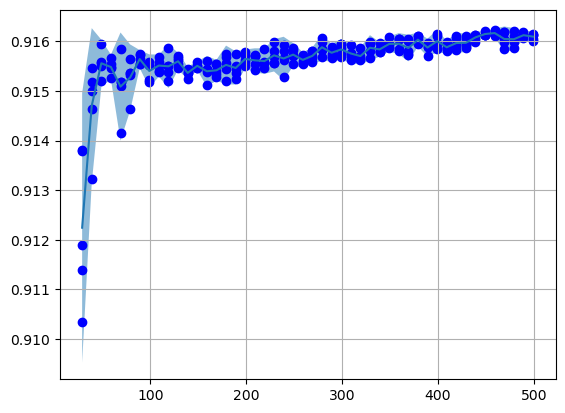

In [20]:
results = np.array(results).reshape(-1, 5)

means = results.mean(axis=1)
stds = results.std(axis=1)

plt.plot(list(range(29, 500, 10)), means)
plt.fill_between(list(range(29, 500, 10)), means - 2*stds, means + 2*stds, alpha=0.5)

for i in range(5):
    plt.scatter(list(range(29, 500, 10)), results[:, i], color='b')

plt.grid()

In [21]:
sec_results = []
sec_results_pca = []

for n in tqdm(range(49, 500, 10)):
    res = []
    res_pca = []
    for _ in range(5):
        slice_inds = np.sort(np.random.choice(list(range(n+1)), 50, replace=False))
        real_slice = real_mfs[:, slice_inds]
        gen_slice = gen_mfs[:, slice_inds]
        lr_r, lr_pca_r = logreg(real_slice, gen_slice), logreg(real_slice, gen_slice, pca=50)
        res.append(lr_r)
        res_pca.append(lr_pca_r)
    sec_results.append([res])
    sec_results_pca.append(res_pca)

100%|██████████| 46/46 [04:25<00:00,  5.77s/it]


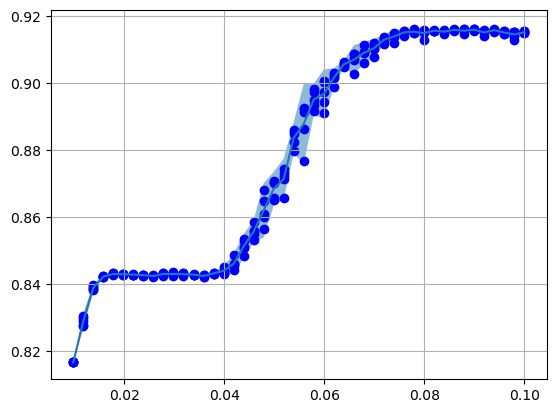

In [22]:
sec_results = np.array(sec_results).reshape(-1, 5)

means = sec_results.mean(axis=1)
stds = sec_results.std(axis=1)

t_s = t[list(range(49, 500, 10))]

plt.plot(t_s, means)
plt.fill_between(t_s, means - 2*stds, means + 2*stds, alpha=0.5)

for i in range(5):
    plt.scatter(t_s, sec_results[:, i], color='b')

plt.grid()

In [23]:
thr_results = []

for n in tqdm(range(49, 500, 10)):
    res = []
    for _ in range(5):
        slice_inds = np.sort(np.random.choice(list(range(500 - (n+1), 500)), 50, replace=False))
        real_slice = real_mfs[:, slice_inds]
        gen_slice = gen_mfs[:, slice_inds]
        lr_r = logreg(real_slice, gen_slice)
        res.append(lr_r)
    thr_results.append([res])


100%|██████████| 46/46 [00:45<00:00,  1.01it/s]


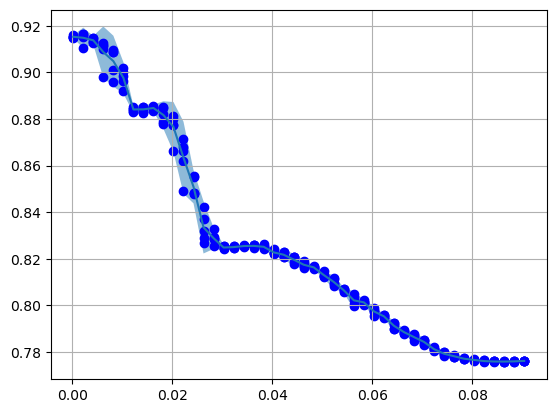

In [25]:
thr_results = np.array(thr_results).reshape(-1, 5)

means = thr_results.mean(axis=1)
stds = thr_results.std(axis=1)

t_s = t[500 - np.arange(49, 500, 10)]

plt.plot(t_s, means)
plt.fill_between(t_s, means - 2*stds, means + 2*stds, alpha=0.5)

for i in range(5):
    plt.scatter(t_s, thr_results[:, i], color='b')

plt.grid()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3134769/1038851871.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.fill_between(list(range(29, 500, 10)), means - 2*stds, means + 2*stds, alpha=0.5, label="$2\sigma$ Confidence Interval")


0.009819648296593188 0.1
0.09038076248496994 0.00020041078156312627


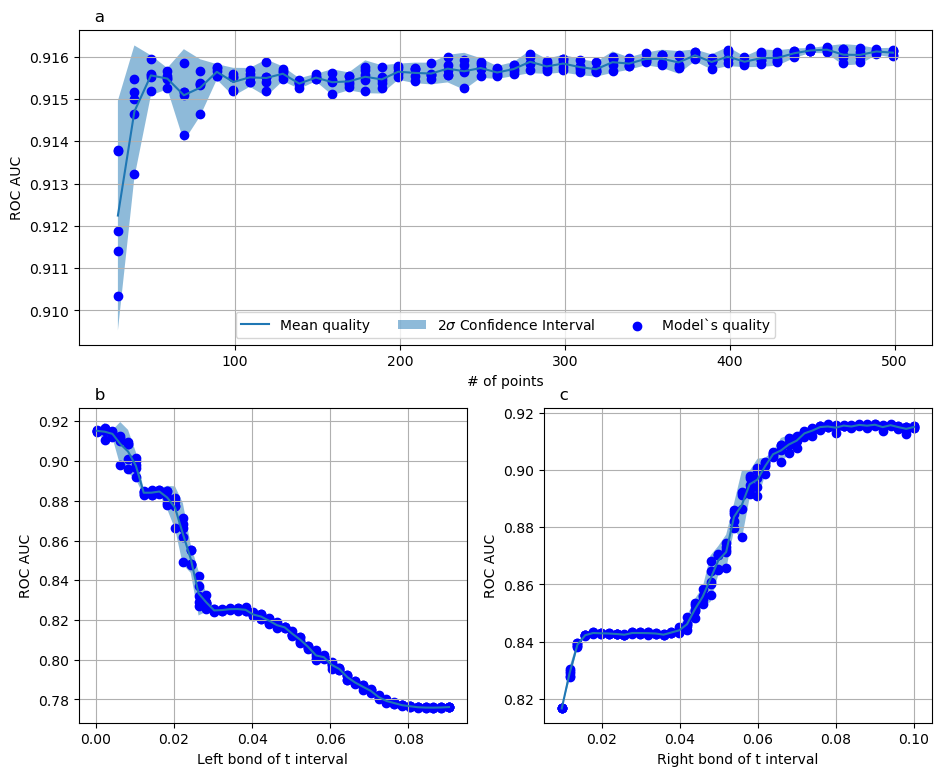

In [57]:
fig = plt.figure(figsize=(11, 9))

ax = plt.subplot2grid((2,1),(0, 0), )
results = np.array(results).reshape(-1, 5)
means = results.mean(axis=1)
stds = results.std(axis=1)
ax.plot(list(range(29, 500, 10)), means, label="Mean quality")
ax.fill_between(list(range(29, 500, 10)), means - 2*stds, means + 2*stds, alpha=0.5, label="$2\sigma$ Confidence Interval")
for i in range(4):
    ax.scatter(list(range(29, 500, 10)), results[:, i], color='b')
ax.scatter(list(range(29, 500, 10)), results[:, 4], color='b', label='Model`s quality')
ax.grid()
ax.set_xlabel("# of points")
ax.set_ylabel("ROC AUC")
ax.set_title("   a", loc='left')
ax.legend(ncols=3, loc='lower center')

ax1 = plt.subplot2grid((2,2),(1,1), )
sec_results = np.array(sec_results).reshape(-1, 5)
means = sec_results.mean(axis=1)
stds = sec_results.std(axis=1)
t_s = t[list(range(49, 500, 10))]
print(t_s[0], t_s[-1])
ax1.plot(t_s, means)
ax1.fill_between(t_s, means - 2*stds, means + 2*stds, alpha=0.5,)
for i in range(5):
    ax1.scatter(t_s, sec_results[:, i], color='b')
ax1.grid()
ax1.set_xlabel("Right bond of t interval")
ax1.set_ylabel("ROC AUC")
ax1.set_title("   c", loc='left')

ax2 = plt.subplot2grid((2,2),(1,0), )
thr_results = np.array(thr_results).reshape(-1, 5)
means = thr_results.mean(axis=1)
stds = thr_results.std(axis=1)
t_s = t[500 - np.arange(49, 500, 10)]
print(t_s[0], t_s[-1])
ax2.plot(t_s, means)
ax2.fill_between(t_s, means - 2*stds, means + 2*stds, alpha=0.5)
for i in range(5):
    ax2.scatter(t_s, thr_results[:, i], color='b')
ax2.grid()
ax2.set_xlabel("Left bond of t interval")
ax2.set_ylabel("ROC AUC")
ax2.set_title("   b", loc='left');